In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import gc
import cv2
import h5py
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
from  matplotlib import pyplot as plt

In [4]:
def read_text_file(path, multi_line=False):
#     if multi_line == True:
#         lines = open(path, 'r', encoding='latin-1').readlines()
#         lines = [line.rstrip('\n') for line in lines]
#         return lines
    return open(path, 'r', encoding='latin-1').read()

def read_image_file(path):
    try:
        image = cv2.imread(path)[:, :, ::-1] #, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)

#         image = tf.keras.utils.load_img(path, target_size=IMAGE_SIZE)
#         image = tf.keras.preprocessing.image.img_to_array(image)
        invalid_ID = -1
    except:
        image = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], NUM_CHANNELS))
        invalid_ID = int(os.path.split(path)[1].split('.')[0])
    return image, invalid_ID

def read_labels_file(path):
    dataframe = pd.read_csv(path, sep="\s+|,", engine="python")
    return dataframe

In [5]:
def get_data_paths(path, extension):
    ''' Get list of data paths with input extension and sort by its filename (ID)
    path: Folder path
    extension: File extension wants to get
    '''
    paths = os.listdir(path)
    paths = list(filter(lambda x: x.endswith(extension), paths))
    paths.sort(key = lambda x : int(x.split('.')[0]))
    paths = [os.path.join(path, x) for x in paths]
    return paths

def get_image_with_id(path):
    filename = os.path.split(path)[1]
    ID = int(filename.split('.')[0])
    image = read_image_file(path)
    return (ID, image)

In [6]:
# there are 3 annotators labelling each modality labels in the MVSA-Multiple dataset
# merge those 3 label pairs into 1 pair by taking majority vote on each modality label
# since there are only 3 different labels, if 1 modality receives 3 different labels from 3 annotators
# => the data pair contains it is considered invalid
def merge_multi_label(dataframe):
    anno_1 = list(dataframe.loc[:, ['text', 'image']].itertuples(index=False, name=None))
    anno_2 = list(dataframe.loc[:, ['text.1', 'image.1']].itertuples(index=False, name=None))
    anno_3 = list(dataframe.loc[:, ['text.2', 'image.2']].itertuples(index=False, name=None))
    IDs = list(dataframe.iloc[:, 0])

    valid_pairs = []

    for i in range(len(anno_1)):
        pairs = [anno_1[i], anno_2[i], anno_3[i]]
        ID = IDs[i]

        text_labels = [pair[0] for pair in pairs]
        image_labels = [pair[1] for pair in pairs]

        max_occur_text_label = max(text_labels, key=text_labels.count)
        max_occur_image_label = max(image_labels, key=image_labels.count)

        if text_labels.count(max_occur_text_label) > 1 and image_labels.count(max_occur_image_label) > 1:
            valid_pair = (ID, max_occur_text_label, max_occur_image_label)
        else:
            valid_pair = (ID, 'invalid', 'invalid')
        valid_pairs.append(valid_pair)
    valid_dataframe = pd.DataFrame(valid_pairs, columns=['ID', 'text', 'image'])
    return valid_dataframe

def multimodal_label(text_label, image_label):
    if text_label == image_label:
        label = text_label
    elif (text_label == 'positive' and image_label == 'negative') or (text_label == 'negative' and image_label == 'positive'):
        label = 'invalid'
    elif (text_label == 'neutral' and image_label != 'neutral') or (text_label != 'neutral' or image_label == 'neutral'):
        label = image_label if text_label == 'neutral' else text_label
    return label

In [7]:
def create_multimodal_labels(path, multiple=False, mappings=False):
    dataframe = read_labels_file(path)

    if multiple == True:
        dataframe = merge_multi_label(dataframe)

    labels = []
    for label_pair in dataframe.loc[:, ['text', 'image']].values:
        label = multimodal_label(label_pair[0], label_pair[1])
        labels.append(label)

    if mappings == True:
        label_map = {}
        for i in range(len(labels)):
            ID = dataframe.iloc[i, 0]
            label_map[ID] = labels[i]
        return label_map

    return np.array(labels, dtype='object')

def create_original_labels(path, multiple=False):
    dataframe = read_labels_file(path)

    if multiple == True:
        dataframe = merge_multi_label(dataframe)

    text_labels = dataframe['text'].to_numpy()
    image_labels = dataframe['image'].to_numpy()
    return text_labels, image_labels

def create_text_data(path):
    texts = []
    text_paths = get_data_paths(path, '.txt')

    print('Read text data')
    for text_path in tqdm(text_paths):
        text = read_text_file(text_path).rstrip('\n')
        texts.append(text)

    return texts

def create_image_data(path):
    images = []
    invalid_indices = []
    image_paths = get_data_paths(path, '.jpg')

    print('Read image data')
    for image_path in tqdm(image_paths):
        image, invalid_ID = read_image_file(image_path)
        images.append(image)

        if invalid_ID != -1:
            invalid_indices.append(invalid_ID)

    images = np.array(images, dtype='uint8')
    return images, invalid_indices

In [8]:
def remove_invalid(data, indices):
    valid_data = []
    for i in range(len(data)):
        if i not in indices:
            valid_data.append(data[i])
    return valid_data

In [9]:
def read_hdf5(path):
    read_file = h5py.File(path, 'r')

    feature_names = list(read_file.keys())
    loaded_data = []

    for name in feature_names:
        dataset = read_file[name][:]
        if dataset.dtype == np.dtype('object'):
            dataset = np.array([x.decode('utf-8') for x in dataset])
        loaded_data.append((name, dataset))

    return loaded_data

In [10]:
def load_mvsa_data(path):
    data = read_hdf5(path)
    for x in data:
        if x[0] == 'texts':
            texts = x[1]
        if x[0] == 'multimodal-labels':
            labels = x[1]
        if x[0] == 'text-labels':
            text_labels = x[1]
        if x[0] == 'image-labels':
            image_labels = x[1]

    images_path = os.path.join(os.path.split(path)[0], os.path.split(path)[1].split('.')[0] + '-images.npz')
    npzfile = np.load(images_path)
    images = npzfile['arr_0']

    return texts, images, labels, text_labels, image_labels

# Read and process raw data

## MVSA-Single

In [11]:
# mvsa_single_texts = create_text_data(mvsa_single_data_path)
# mvsa_single_images, mvsa_single_images_invalid_indices = create_image_data(mvsa_single_data_path)
# mvsa_single_multimodal_labels = create_multimodal_labels(mvsa_single_label_path)
# mvsa_single_text_labels, mvsa_single_image_labels = create_original_labels(mvsa_single_label_path)


In [12]:

mvsa_single_texts_loaded, mvsa_single_images_loaded, \
mvsa_single_multimodal_labels_loaded, mvsa_single_text_labels_loaded, \
mvsa_single_image_labels_loaded = load_mvsa_data('/content/drive/MyDrive/mvsa-data/mvsa-single-4511.hdf5')



In [13]:
# Get duplicated text indices
# mvsa_single_texts_unique_indices = np.unique(mvsa_single_texts, return_index=True)[1]
# mvsa_single_texts_duplicated_indices = [i for i in range(num_mvsa_single) if i not in mvsa_single_texts_unique_indices]

# Get invalid label indices
num_mvsa_single = 4511
mvsa_single_multimodal_labels_invalid_indices = [i for i in range(num_mvsa_single) if mvsa_single_multimodal_labels_loaded[i] == 'invalid']
mvsa_single_multimodal_labels_invalid_indices

[]

In [14]:
print('Number of text-image pair in MVSA-Single:', num_mvsa_single)

# mvsa_single_invalid_indices = []
# # mvsa_single_invalid_indices.extend(mvsa_single_texts_duplicated_indices)
# mvsa_single_invalid_indices.extend(mvsa_single_images_invalid_indices) # corrupted images
# mvsa_single_invalid_indices.extend(mvsa_single_multimodal_labels_invalid_indices)
# mvsa_single_invalid_indices = list(set(mvsa_single_invalid_indices))
# print('Number of invalid data in MVSA-Single:', len(mvsa_single_invalid_indices))

# mvsa_single_texts_valid = remove_invalid(mvsa_single_texts, mvsa_single_invalid_indices)
# mvsa_single_images_valid = remove_invalid(mvsa_single_images, mvsa_single_invalid_indices)
# mvsa_single_multimodal_labels_valid = remove_invalid(mvsa_single_multimodal_labels, mvsa_single_invalid_indices)
# mvsa_single_text_labels_valid = remove_invalid(mvsa_single_text_labels, mvsa_single_invalid_indices)
# mvsa_single_image_labels_valid = remove_invalid(mvsa_single_image_labels, mvsa_single_invalid_indices)

# num_mvsa_single_valid = len(mvsa_single_texts_valid)
# print('Number of text-image pair in MVSA-Single after removing invalid data:', num_mvsa_single_valid)

Number of text-image pair in MVSA-Single: 4511


In [15]:
# save and load check data
# with h5py.File('mvsa-single-{}.hdf5'.format(num_mvsa_single_valid), 'w') as f:
#     f.create_dataset('texts', data = mvsa_single_texts_valid)
# #     f.create_dataset('images', data = mvsa_single_images_valid)
#     f.create_dataset('multimodal-labels', data = mvsa_single_multimodal_labels_valid)
#     f.create_dataset('text-labels', data = mvsa_single_text_labels_valid)
#     f.create_dataset('image-labels', data = mvsa_single_image_labels_valid)

# np.savez('./mvsa-single-{}-images'.format(num_mvsa_single_valid), mvsa_single_images_valid)


## MVSA-Multiple

In [16]:
mvsa_multiple_texts_loaded, mvsa_multiple_images_loaded, \
mvsa_multiple_multimodal_labels_loaded, mvsa_multiple_text_labels_loaded, \
mvsa_multiple_image_labels_loaded = load_mvsa_data('/content/drive/MyDrive/mvsa-data/mvsa-multiple-17024.hdf5')

In [17]:
# mvsa_multiple_texts = create_text_data(mvsa_multiple_data_path)
# mvsa_multiple_images, mvsa_multiple_images_invalid_indices = create_image_data(mvsa_multiple_data_path)
# mvsa_multiple_multimodal_labels = create_multimodal_labels(mvsa_multiple_label_path, multiple=True)
# mvsa_multiple_text_labels, mvsa_multiple_image_labels = create_original_labels(mvsa_multiple_label_path, multiple=True)
# num_mvsa_multiple = len(mvsa_multiple_texts)

In [18]:
# Get duplicated text indices
# mvsa_multiple_texts_unique_indices = np.unique(mvsa_multiple_texts, return_index=True)[1]
# mvsa_multiple_texts_duplicated_indices = [i for i in range(num_mvsa_multiple) if i not in mvsa_multiple_texts_unique_indices]

# Get invalid label indices
mvsa_multiple_multimodal_labels_invalid_indices = [i for i in range(17024) if mvsa_multiple_multimodal_labels_loaded[i] == 'invalid']

In [19]:
# print('Number of text-image pair in MVSA-Multiple:', num_mvsa_multiple)

# mvsa_multiple_invalid_indices = []
# # mvsa_multiple_invalid_indices.extend(mvsa_multiple_texts_duplicated_indices)
# mvsa_multiple_invalid_indices.extend(mvsa_multiple_images_invalid_indices)
# mvsa_multiple_invalid_indices.extend(mvsa_multiple_multimodal_labels_invalid_indices)
# mvsa_multiple_invalid_indices = list(set(mvsa_multiple_invalid_indices))
# print('Number of invalid data in MVSA-Multiple:', len(mvsa_multiple_invalid_indices))

# mvsa_multiple_texts_valid = remove_invalid(mvsa_multiple_texts, mvsa_multiple_invalid_indices)
# mvsa_multiple_images_valid = remove_invalid(mvsa_multiple_images, mvsa_multiple_invalid_indices)
# mvsa_multiple_multimodal_labels_valid = remove_invalid(mvsa_multiple_multimodal_labels, mvsa_multiple_invalid_indices)
# mvsa_multiple_text_labels_valid = remove_invalid(mvsa_multiple_text_labels, mvsa_multiple_invalid_indices)
# mvsa_multiple_image_labels_valid = remove_invalid(mvsa_multiple_image_labels, mvsa_multiple_invalid_indices)

# num_mvsa_multiple_valid = len(mvsa_multiple_texts_valid)
# print('Number of text-image pair in MVSA-Multiple after removing invalid data:', num_mvsa_multiple_valid)

In [20]:
# # save data to file
# with h5py.File('mvsa-multiple-{}.hdf5'.format(num_mvsa_multiple_valid), 'w') as f:
#     f.create_dataset('texts', data = mvsa_multiple_texts_valid)
# #     f.create_dataset('images', data = a, compression="gzip")
#     f.create_dataset('multimodal-labels', data = mvsa_multiple_multimodal_labels_valid)
#     f.create_dataset('text-labels', data = mvsa_multiple_text_labels_valid)
#     f.create_dataset('image-labels', data = mvsa_multiple_image_labels_valid)

# # save as npz since h5py has a memory issues when saving upto 16k data somehow but 13k was fine :)
# np.savez('./mvsa-multiple-{}-images'.format(num_mvsa_multiple_valid), mvsa_multiple_images_valid)

# Visualization

In [21]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
#os.makedirs('./plots')

In [23]:
mvsa_single_multimodal_labels_valid = np.array(mvsa_single_multimodal_labels_loaded)
mvsa_multiple_multimodal_labels_valid = np.array(mvsa_multiple_multimodal_labels_loaded)

In [24]:
mvsa_single_num_pos = (mvsa_single_multimodal_labels_loaded == 'positive').sum()
mvsa_single_num_neg = (mvsa_single_multimodal_labels_loaded == 'negative').sum()
mvsa_single_num_neu = (mvsa_single_multimodal_labels_loaded == 'neutral').sum()

mvsa_multiple_num_pos = (mvsa_multiple_multimodal_labels_loaded == 'positive').sum()
mvsa_multiple_num_neg = (mvsa_multiple_multimodal_labels_loaded == 'negative').sum()
mvsa_multiple_num_neu = (mvsa_multiple_multimodal_labels_loaded == 'neutral').sum()

In [25]:
def get_label_num(data_labels, name=''):
    unique_labels = np.unique(data_labels)
    num_labels = [(data_labels == label).sum() for label in  unique_labels]
    dataframe = pd.DataFrame(np.reshape(num_labels, (1, -1)), columns=unique_labels, index=[name])
    return dataframe

In [26]:
print('MVSA dataset after removing invalid and duplicated data')
mvsa_single_valid_label = get_label_num(mvsa_single_multimodal_labels_loaded, 'MVSA-Single')
mvsa_multiple_valid_label = get_label_num(mvsa_multiple_multimodal_labels_loaded, 'MVSA-Multiple')
mvsa_valid_label = get_label_num(np.append(mvsa_single_multimodal_labels_loaded, mvsa_multiple_multimodal_labels_loaded, axis=0), 'Total MVSA')
mvsa_valid_label = pd.concat([mvsa_single_valid_label, mvsa_multiple_valid_label, mvsa_valid_label])
mvsa_valid_label['total'] = mvsa_valid_label.sum(axis = 1)
mvsa_valid_label
#print(mvsa_single_valid_label, mvsa_single_multimodal_labels_valid)

MVSA dataset after removing invalid and duplicated data


negative  neutral  positive  total
MVSA-Single        1358      470      2683   4511
MVSA-Multiple      1299     4407     11318  17024
Total MVSA         2657     4877     14001  21535

In [27]:
WIDTH = 650
HEIGHT = 400
fig = px.bar(mvsa_valid_label.T.drop('total'), orientation='h')
fig.update_traces(width=0.7)
fig.update_layout(margin_b=25, margin_t=35, margin_l=25, margin_r=25, width=WIDTH, height=HEIGHT)
fig.update_layout(title=' MVSA-Single and MVSA-Multiple',
                  xaxis_title='Number of labels',
                  yaxis_title='Sentiment', legend_title='Legend')
#fig.write_html('./plots/label-statistics.html')
fig.show()

In [28]:
num_mvsa_single_valid=4511
positive_image_indices = [i for i in range(num_mvsa_single_valid) if mvsa_single_image_labels_loaded[i] == 'positive']
negative_image_indices = [i for i in range(num_mvsa_single_valid) if mvsa_single_image_labels_loaded[i] == 'negative']
neutral_image_indices = [i for i in range(num_mvsa_single_valid) if mvsa_single_image_labels_loaded[i] == 'neutral']

"RT @Beltrew: Enthusiastic hello from the kids of Zarqa #Jordan-a poor area where many of the country's extremists come from "

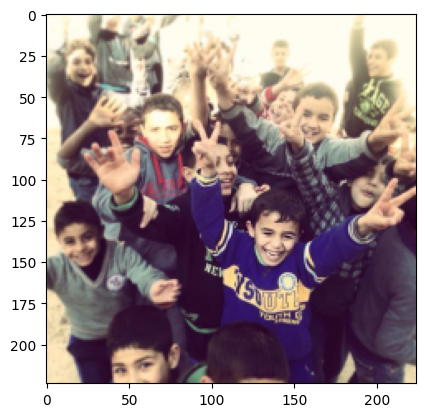

In [57]:
index=positive_image_indices[20]
plt.imshow(mvsa_single_images_loaded[index])
mvsa_single_texts_loaded[index]

Positive images


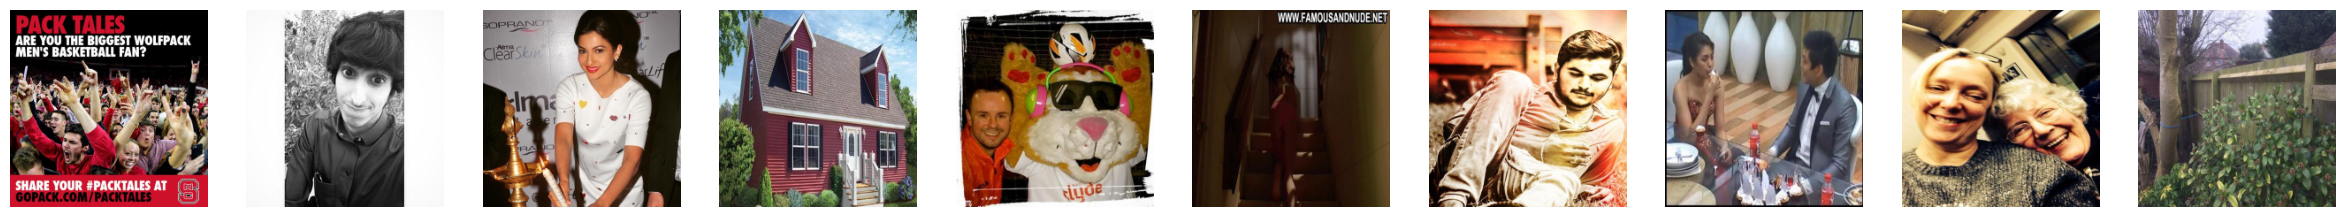

In [29]:
rows = 1
columns = 10

fig = plt.figure(figsize=(30, 5))
print('Positive images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    random_index = random.choice(positive_image_indices)
    plt.imshow(mvsa_single_images_loaded[random_index])
    plt.axis('off')
plt.show()

Negative images


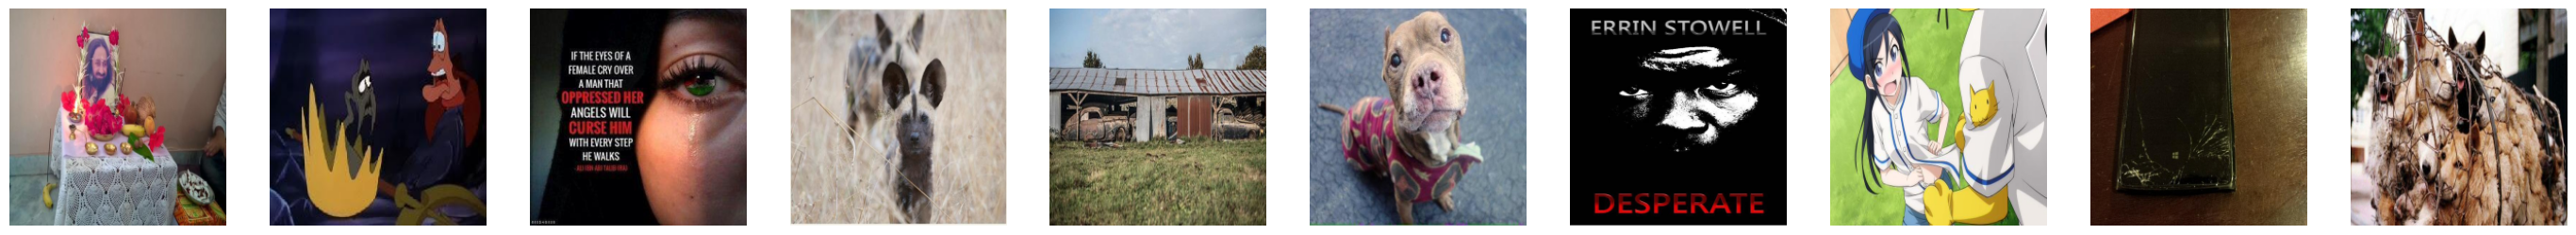

In [30]:
fig = plt.figure(figsize=(35, 10))
print('Negative images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    random_index = random.choice(negative_image_indices)
    plt.imshow(mvsa_single_images_loaded[random_index])
    plt.axis('off')
plt.show()

Neutral images


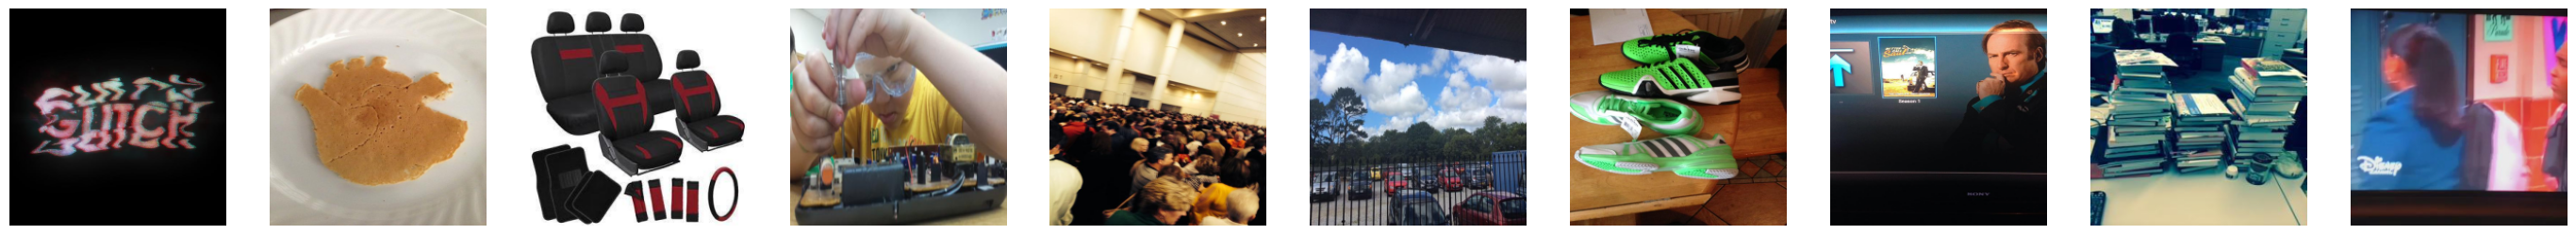

In [31]:
fig = plt.figure(figsize=(35, 10))
print('Neutral images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    random_index = random.choice(neutral_image_indices)
    plt.imshow(mvsa_single_images_loaded[random_index])
    plt.axis('off')
plt.show()

Positive images


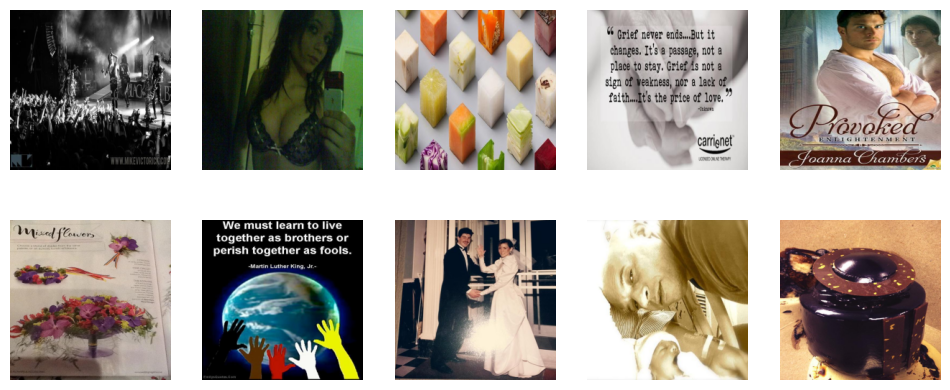

Negative images


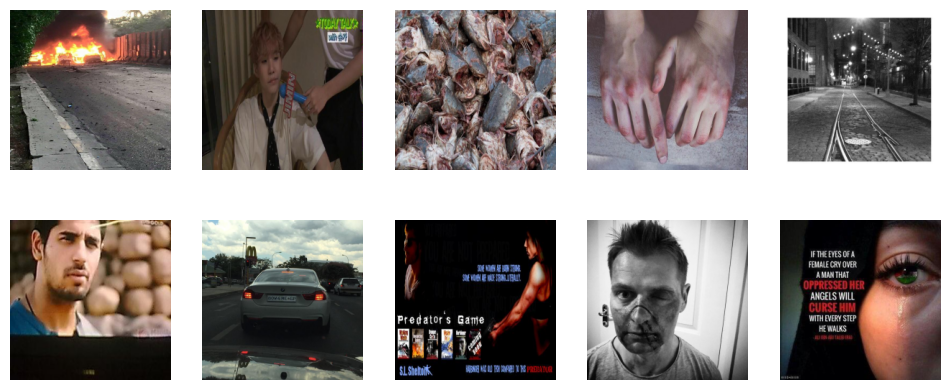

Neutral images


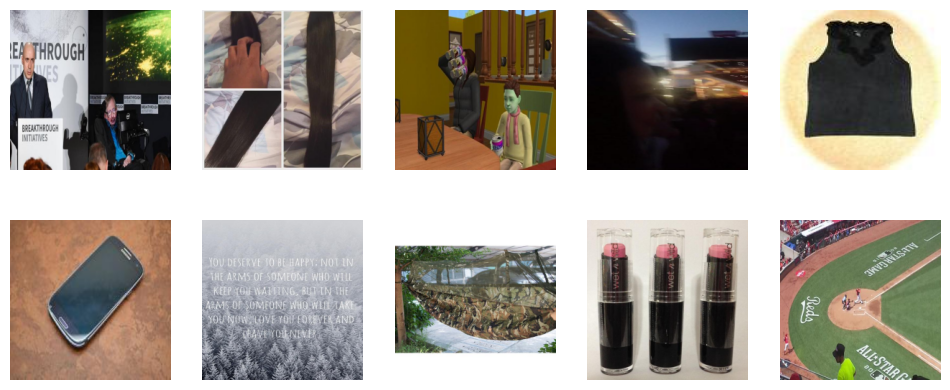

In [32]:
rows = 2
columns = 5

fig = plt.figure(figsize=(12, 5))
print('Positive images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    random_index = random.choice(positive_image_indices)
    plt.imshow(mvsa_single_images_loaded[random_index])
    plt.axis('off')
#plt.savefig('./plots/images_positive.png')
plt.show()

fig = plt.figure(figsize=(12, 5))
print('Negative images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    random_index = random.choice(negative_image_indices)
    plt.imshow(mvsa_single_images_loaded[random_index])
    plt.axis('off')
#plt.savefig('./plots/images_negative.png')
plt.show()

fig = plt.figure(figsize=(12, 5))
print('Neutral images')
for i in range(10):
    fig.add_subplot(rows, columns, i + 1)
    random_index = random.choice(neutral_image_indices)
    plt.imshow(mvsa_single_images_loaded[random_index])
    plt.axis('off')
#plt.savefig('./plots/images_neutral.png')
plt.show()

In [33]:
mvsa_single_texts_loaded

array(['How I feel today #legday #jelly #aching #gym ',
       'grattis min griskulting!!!???? va bara tvungen oki s? sch ? @ingenkommeratttrodig #pig #happybday #wow #lovely #cut¡\xad ',
       'RT @polynminion: The moment I found my favourite tV character. #PROFOUNDLOVE ',
       ...,
       'RT @bookmyshow: #Disney\'s lies - "Every day is a good hair day". Yeah, right!!: http://t.co/351AQVV7gA http://t.co/fFH59wGwbs',
       'RT @MUBMI: TWO MORE DAYS to submit your apps #mizzou19 http://t.co/aqhTljfgIG http://t.co/cftTb6ok5b',
       "RT @khununeos: khun was literally me whenever I gotta see junho's sinful butt- lol (crtto) http://t.co/y3IvvUTRYT"],
      dtype='<U257')

In [34]:
# if mvsa_single_texts_loaded[2].startswith('RT'):
#         txt = ''.join(mvsa_single_texts_loaded[2].split(':')[1:])
# txt = mvsa_single_texts_loaded[2].strip().lower()
# txt=clean_text(np.array_str(mvsa_single_texts_loaded[2]))
# print(txt)


import re
import string

at_pattern = re.compile('@[a-zA-Z0-9]+')
http_pattern = re.compile("((http|ftp|https)://)(([a-zA-Z0-9\._-]+\.[a-zA-Z]{2,6})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(:[0-9]{1,4})*(/[a-zA-Z0-9\&%_\./-~-]*)?")
punc_pattern = re.compile('[%s]' % re.escape(string.punctuation))
print(mvsa_single_texts_loaded[2])
txt = re.sub('#', '', mvsa_single_texts_loaded[2])
print(txt)
txt = re.sub(at_pattern, 'user', txt)
print(txt)
txt = re.sub(http_pattern, 'link', txt)
print(txt)
if txt.startswith('RT user'):
  txt = ''.join(txt.split(':')[1:])
print(txt)
txt = re.sub(punc_pattern, '', txt)
print(txt)
#txt.split(':')[1:]
# ONLY REMOVE punc for word2vec not BERT
# as the data was crawled using Twitter API, it marked retweet data with RT <user> tag which has no meaning considering it in training

txt = txt.strip().lower()
print(txt)

RT @polynminion: The moment I found my favourite tV character. #PROFOUNDLOVE 
RT @polynminion: The moment I found my favourite tV character. PROFOUNDLOVE 
RT user: The moment I found my favourite tV character. PROFOUNDLOVE 
RT user: The moment I found my favourite tV character. PROFOUNDLOVE 
 The moment I found my favourite tV character. PROFOUNDLOVE 
 The moment I found my favourite tV character PROFOUNDLOVE 
the moment i found my favourite tv character profoundlove


In [35]:
import re
import string
def clean_text(txt):
    at_pattern = re.compile('@[a-zA-Z0-9]+')
    http_pattern = re.compile("((http|ftp|https)://)(([a-zA-Z0-9\._-]+\.[a-zA-Z]{2,6})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(:[0-9]{1,4})*(/[a-zA-Z0-9\&%_\./-~-]*)?")
    punc_pattern = re.compile('[%s]' % re.escape(string.punctuation))
    txt = re.sub('#', '', txt)
    txt = re.sub(at_pattern, 'user', txt)
    txt = re.sub(http_pattern, 'link', txt)
    # as the data was crawled using Twitter API, it marked retweet data with RT <user> tag which has no meaning considering it in training
    if txt.startswith('RT user'):
      txt = ''.join(txt.split(':')[1:])
    txt = re.sub(punc_pattern, '', txt) # ONLY REMOVE punc for word2vec not BERT
    txt = txt.strip().lower()
    return txt

def get_clean_texts(data):
    cleaned_data = []
    for line in data:
        text = clean_text(line)
        cleaned_data.append(text)
    return cleaned_data

In [36]:
mvsa_texts_valid = get_clean_texts(np.concatenate((mvsa_single_texts_loaded, mvsa_multiple_texts_loaded)))
mvsa_labels_valid = get_clean_texts(np.concatenate((mvsa_single_multimodal_labels_loaded, mvsa_multiple_multimodal_labels_loaded)))

In [37]:
mvsa_texts_valid[:10],

(['how i feel today legday jelly aching gym',
  'grattis min griskulting va bara tvungen oki s sch  user pig happybday wow lovely cut¡\xad',
  'the moment i found my favourite tv character profoundlove',
  'escort we have a young and energetic team and we pride ourselves on offering the highes hoer',
  'went to ssc today to be a movie star to rep for the deaf and got to meet an energetic great guy mark white',
  'that was really energetic',
  'to my most hard workingfun loving and energetic teamthank you and i love you',
  'energetic training today with our san antonio new dollarsnew partners trainees',
  'look at their photo and feel the anger speakup for peace speak up for equality speak up for tolerance',
  'user absolute disgrace two carriages from bangor half way there standing room only disgraced'],)

In [38]:
np.concatenate((mvsa_single_texts_loaded, mvsa_multiple_texts_loaded))[:10]

array(['How I feel today #legday #jelly #aching #gym ',
       'grattis min griskulting!!!???? va bara tvungen oki s? sch ? @ingenkommeratttrodig #pig #happybday #wow #lovely #cut¡\xad ',
       'RT @polynminion: The moment I found my favourite tV character. #PROFOUNDLOVE ',
       '#escort We have a young and energetic team and we pride ourselves on offering the highes #hoer ',
       'RT @chrisashaffer: Went to SSC today to be a "movie star" to rep for the Deaf and got to meet an energetic great guy: Mark White! ',
       'RT @babeshawnmendes: "that was really energetic" ',
       'RT @deepikapadukone: To my most hard working,fun loving and energetic team...Thank you and I love you! ',
       'Energetic training today with our San Antonio New Dollars/New Partners trainees ',
       'Look at their Photo and feel the #Anger. #SpeakUp for #peace. Speak up for #equality. Speak up for #Tolerance. ',
       '@ArrivaTW absolute disgrace two carriages from Bangor half way there standing room

In [39]:
len(mvsa_labels_valid), len(mvsa_texts_valid)

(21535, 21535)

In [40]:
mvsa_texts_positive = []
mvsa_texts_negative = []
mvsa_texts_neutral = []
for i in range(len(mvsa_labels_valid)):
    x = mvsa_labels_valid[i]
    y = mvsa_texts_valid[i]
    if x == 'positive':
        mvsa_texts_positive.append(y)
    if x == 'negative':
        mvsa_texts_negative.append(y)
    if x == 'neutral':
        mvsa_texts_neutral.append(y)

In [41]:
# for graphing
len_positive = [len(n) for n in mvsa_texts_positive]
len_negative = [len(n) for n in mvsa_texts_negative]
len_neutral = [len(n) for n in mvsa_texts_neutral]


In [42]:
# import plotly.figure_factory as ff

# x = np.random.randn(1000)
# hist_data = [len_positive, len_negative, len_neutral]
# group_labels = ['positive', 'negative', 'neutral'] # name of the dataset

# fig = ff.create_distplot(hist_data, group_labels, curve_type='kde',
#                          show_hist=False, show_rug=False, colors=['green', 'red', 'blue'])
# fig.update_layout(margin_b=25, margin_t=35, margin_l=25, margin_r=25, width=WIDTH, height=HEIGHT)
# fig.update_layout(title='Phân bố số từ ở từng nhãn',
#                   xaxis_title='Số lượng nhãn',
#                   yaxis_title='Số từ', legend_title='Nhãn')
# #fig.write_html('./plots/label-count.html')
# fig.show()

In [43]:
#mvsa_texts_valid, mvsa_labels_valid

#find index of positive
mvsa_labels_valid

['positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'neutral',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'negati

# Input preprocessing

In [ ]:
#pip install transformers

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 100000
# This is fixed.
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(mvsa_texts_valid)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 34314 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(mvsa_texts_valid)

In [ ]:
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 128
X = pad_sequences(X, MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (21535, 128)


In [ ]:
X[134]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0, 134, 216], dtype=int32)

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, mvsa_labels_valid)

In [ ]:
len(y_res)

42003

In [ ]:
#print(mvsa_labels_valid)
Y = pd.get_dummies(mvsa_labels_valid)
print(Y)
print('Shape of label tensor:', Y.shape)

       negative  neutral  positive
0             0        0         1
1             0        0         1
2             0        0         1
3             0        0         1
4             0        0         1
...         ...      ...       ...
21530         0        0         1
21531         0        1         0
21532         0        0         1
21533         0        0         1
21534         0        0         1

[21535 rows x 3 columns]
Shape of label tensor: (21535, 3)


In [ ]:
type(Y)

pandas.core.frame.DataFrame

In [ ]:
from sklearn.model_selection import train_test_split
#clean_text_data=np.array(clean_text_data)
#mvsa_single_multimodal_labels_valid=np.array(mvsa_single_multimodal_labels_valid)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20,shuffle=True, stratify=Y)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(17228, 128) (17228, 3)
(4307, 128) (4307, 3)


In [ ]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test,Y_test, test_size = 0.50)
print(X_test.shape,Y_test.shape)
print(X_val.shape,Y_val.shape)

(2153, 128) (2153, 3)
(2154, 128) (2154, 3)


In [ ]:
mvsa_valid_label = get_label_num(np.append(mvsa_single_multimodal_labels_loaded, mvsa_multiple_multimodal_labels_loaded, axis=0), 'Total MVSA')


In [ ]:
print('Postive Numbers = ',Y_train[Y_train['positive']==1].shape[0])
print('negative Numbers = ',Y_train[Y_train['negative']==1].shape[0])
print('neutral Numbers = ',Y_train[Y_train['neutral']==1].shape[0])

Postive Numbers =  11201
negative Numbers =  2125
neutral Numbers =  3902


In [ ]:
print('Postive Numbers = ',Y_test[Y_test['positive']==1].shape[0])
print('negative Numbers = ',Y_test[Y_test['negative']==1].shape[0])
print('neutral Numbers = ',Y_test[Y_test['neutral']==1].shape[0])

Postive Numbers =  1434
negative Numbers =  259
neutral Numbers =  460


In [ ]:
Y_train.to_numpy().argmax(axis=1)

array([2, 2, 2, ..., 2, 1, 0])

In [ ]:
mvsa_valid_label

negative  neutral  positive
Total MVSA      2657     4877     14001

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Conv1D, MaxPooling1D,Flatten
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import Bidirectional, Dropout


In [ ]:
import os
import numpy as np
def load_embeddingMatrix(path,embedding_dim, max_words):
    glove_dir = path
    embeddings_index = {}

    # Open the file with UTF-8 encoding
    with open(os.path.join(glove_dir, 'glove.42B.300d.txt'), encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))
    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
embedding_matrix=load_embeddingMatrix('/content/drive/MyDrive/',300, 100000)

Found 1917495 word vectors.


In [ ]:
NUM_CLASSES=3

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 7.8 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa
f1_macro = tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', name='f1_macro')
f1_weighted = tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='weighted', name='f1_weighted')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning:



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 




In [ ]:
adam=tf.keras.optimizers.Adam(learning_rate=2e-4)

## **LSTM**

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.src.utils.layer_utils import initializers

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1],weights=[embedding_matrix],trainable=False))
model.add(LSTM(100, dropout=0.9, recurrent_dropout=0.9, kernel_initializer='he_normal'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Output shape is (batch_size, 3) for 3 classes

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', f1_macro, f1_weighted])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 128, 300)          30000000  
                                                                 
 lstm_2 (LSTM)               (None, 100)               160400    
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 10)                510       
                                                                 
 dense_8 (Dense)             (None, 3)                 33        
                                                                 
Total params: 30165993 (115.07 MB)
Trainable params: 165993 (648.41 KB)
Non-trainable params: 30000000 (114.44 MB)
_________________________________________________________________


In [ ]:
#    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                 patience=5, min_lr=0.001)
 #   model.fit(X_train, Y_train, callbacks=[reduce_lr])

NameError: ignored

In [ ]:
epochs = 10
batch_size = 128
history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val,Y_val))
#, callbacks=[reduce_lr])

Epoch 1/10
539/539 [==============================] - 219s 398ms/step - loss: 0.9234 - accuracy: 0.6171 - f1_macro: 0.3074 - f1_weighted: 0.5309 - val_loss: 0.9704 - val_accuracy: 0.6342 - val_f1_macro: 0.2587 - val_f1_weighted: 0.4922
Epoch 2/10
539/539 [==============================] - 222s 411ms/step - loss: 0.8722 - accuracy: 0.6501 - f1_macro: 0.2627 - f1_weighted: 0.5123 - val_loss: 0.8965 - val_accuracy: 0.6342 - val_f1_macro: 0.2587 - val_f1_weighted: 0.4922
Epoch 3/10
539/539 [==============================] - 225s 417ms/step - loss: 0.8636 - accuracy: 0.6502 - f1_macro: 0.2627 - f1_weighted: 0.5123 - val_loss: 0.8728 - val_accuracy: 0.6342 - val_f1_macro: 0.2587 - val_f1_weighted: 0.4922
Epoch 4/10
539/539 [==============================] - 216s 401ms/step - loss: 0.8533 - accuracy: 0.6502 - f1_macro: 0.2627 - f1_weighted: 0.5123 - val_loss: 0.8684 - val_accuracy: 0.6342 - val_f1_macro: 0.2587 - val_f1_weighted: 0.4922
Epoch 5/10
539/539 [==============================] - 21

In [ ]:
model.evaluate(X_test,np.array(Y_test))
#print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

68/68 [==============================] - 12s 179ms/step - loss: 0.7617 - accuracy: 0.6818 - f1_macro: 0.3663 - f1_weighted: 0.5737


[0.761730968952179, 0.6818392872810364, 0.3663162887096405, 0.5737167596817017]

In [ ]:
#loss, acc, f1_macro, f1_weighted

In [ ]:
y_pred1=model.predict(X_test)
print(y_pred1.shape)


68/68 [==============================] - 13s 190ms/step
(2153, 3)


In [ ]:
y_pred_class = y_pred1.argmax(axis=1)


In [ ]:
y_test1=np.argmax(np.array(Y_test),axis=1)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print("Performance Metrics: ")
metrics=classification_report(y_test1,y_pred_class)
print(metrics)

Performance Metrics: 
              precision    recall  f1-score   support

           0       0.62      0.19      0.29       259
           1       0.00      0.00      0.00       460
           2       0.68      0.99      0.81      1434

    accuracy                           0.68      2153
   macro avg       0.43      0.39      0.37      2153
weighted avg       0.53      0.68      0.57      2153



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
confusion_matrix(y_test1,y_pred_class)
#from sklearn.metrics import plot_confusion_matrix
#plot_confusion_matrix(model, X_test, Y_test, cmap=plt.cm.Blues)
#plt.show()

array([[  49,    0,  210],
       [  15,    0,  445],
       [  15,    0, 1419]])

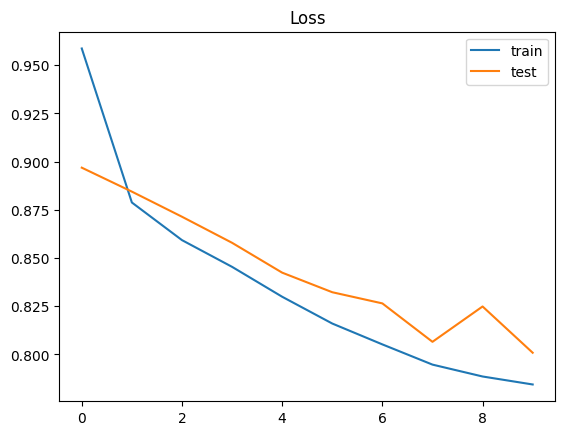

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

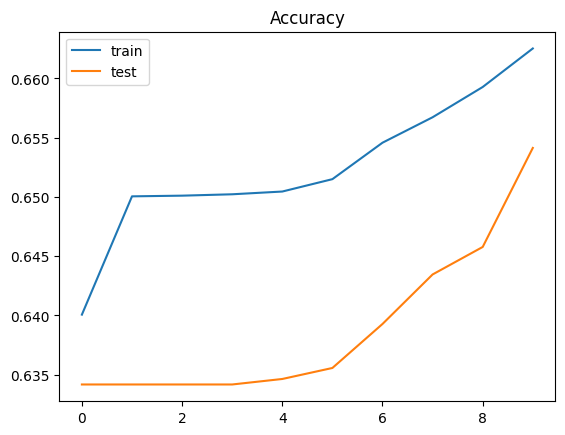

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test1,y_pred_class)
auc_rf = auc(fpr_rf, tpr_rf)
#plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

ValueError: ignored

**Bi-LSTM**

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense

# Create a Sequential model
model_Bi = Sequential()

# Add an Embedding layer with appropriate input dimensions
model_Bi.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1],weights=[embedding_matrix],trainable=False))

# Add Bidirectional LSTM layers
model_Bi.add(Bidirectional(LSTM(64, return_sequences=True,dropout=0.5, recurrent_dropout=0.5)))
model_Bi.add(Bidirectional(LSTM(32, return_sequences=True,dropout=0.5, recurrent_dropout=0.5)))
model_Bi.add(Bidirectional(LSTM(16, return_sequences=False,dropout=0.5, recurrent_dropout=0.5)))

# Add a Dense layer with 3 units and softmax activation for classification
model_Bi.add(Dense(3, activation='softmax'))

# Compile the model with appropriate loss, optimizer, and metrics
model_Bi.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), metrics=['accuracy', f1_macro, f1_weighted])

# Print a summary of the model's architecture
model_Bi.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 128, 300)          30000000  
                                                                 
 bidirectional (Bidirection  (None, 128, 128)          186880    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128, 64)           41216     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                        

In [ ]:
epochs = 10
batch_size = 128
history_Bi = model_Bi.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_val,Y_val))

Epoch 1/10
122/122 [==============================] - 475s 4s/step - loss: 1.0388 - accuracy: 0.5955 - f1_macro: 0.3287 - f1_weighted: 0.5326 - val_loss: 0.9682 - val_accuracy: 0.6390 - val_f1_macro: 0.2600 - val_f1_weighted: 0.4984
Epoch 2/10
122/122 [==============================] - 440s 4s/step - loss: 0.9456 - accuracy: 0.6512 - f1_macro: 0.2635 - f1_weighted: 0.5140 - val_loss: 0.9024 - val_accuracy: 0.6390 - val_f1_macro: 0.2599 - val_f1_weighted: 0.4983
Epoch 3/10
122/122 [==============================] - 441s 4s/step - loss: 0.8924 - accuracy: 0.6514 - f1_macro: 0.2630 - f1_weighted: 0.5139 - val_loss: 0.8889 - val_accuracy: 0.6390 - val_f1_macro: 0.2599 - val_f1_weighted: 0.4983
Epoch 4/10
122/122 [==============================] - 430s 4s/step - loss: 0.8748 - accuracy: 0.6514 - f1_macro: 0.2630 - f1_weighted: 0.5139 - val_loss: 0.8885 - val_accuracy: 0.6390 - val_f1_macro: 0.2599 - val_f1_weighted: 0.4983
Epoch 5/10
122/122 [==============================] - 428s 3s/step -

In [ ]:
accr_bi = model_Bi.evaluate(X_test,np.array(Y_test))
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_bi[0],accr_bi[1]))

135/135 [==============================] - 31s 229ms/step - loss: 0.8148 - accuracy: 0.6501 - f1_macro: 0.2627 - f1_weighted: 0.5123
Test set
  Loss: 0.815
  Accuracy: 0.650


In [ ]:
y_pred_bi=model_Bi.predict(X_test)
print(y_pred_bi.shape)

In [ ]:
y_pred_class_bi = y_pred_bi.argmax(axis=1)
y_test1=np.argmax(np.array(Y_test),axis=1)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print("Performance Metrics: ")
metrics=classification_report(y_test1,y_pred_class_bi)
print(metrics)

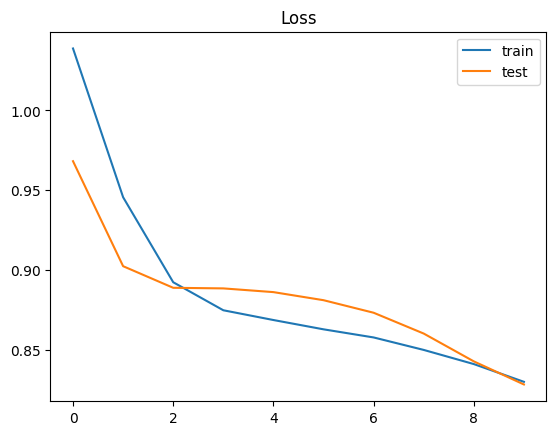

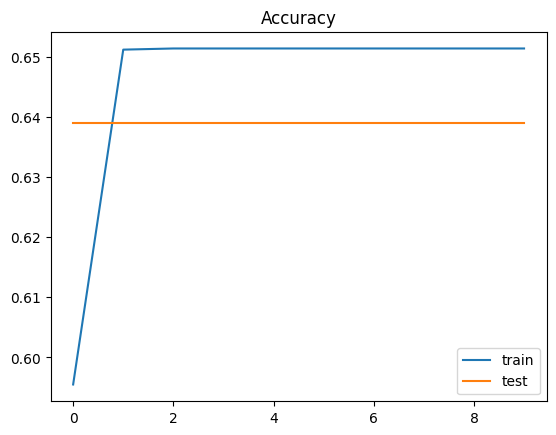

In [ ]:
plt.title('Loss')
plt.plot(history_Bi.history['loss'], label='train')
plt.plot(history_Bi.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.title('Accuracy')
plt.plot(history_Bi.history['accuracy'], label='train')
plt.plot(history_Bi.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# With Attention

In [ ]:
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense,LSTM,Attention
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

In [ ]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

**LSTM+Attention**

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 128
# This is fixed.
EMBEDDING_DIM = 300

In [ ]:
X.shape

(21535, 128)

In [ ]:
def create_LSTM_with_attention(hidden_units, dense_units, input_shape, activation):
    x=Input(shape=input_shape)
    emb_layer=Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1],weights=[embedding_matrix],trainable=False)(x)
    lstm_layer = LSTM(hidden_units, return_sequences=True, activation='relu',dropout=0.5, recurrent_dropout=0.5)(emb_layer)
    attention_layer = attention()(lstm_layer)
    outputs=Dense(256, trainable=True)(attention_layer)
    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)

    model=Model(x,outputs)
    return model

# Create the model with attention, train and evaluate
model_attention = create_LSTM_with_attention(hidden_units=1000, dense_units=3,
                                  input_shape=(128,), activation='softmax')
model_attention.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 300)          30000000  
                                                                 
 lstm (LSTM)                 (None, 128, 1000)         5204000   
                                                                 
 attention (attention)       (None, 1000)              1128      
                                                                 
 dense_1 (Dense)             (None, 3)                 3003      
                                                                 
Total params: 35208131 (134.31 MB)
Trainable params: 5208131 (19.87 MB)
Non-trainable params: 30000000 (114.44 MB)
_________________________________________________________________


In [ ]:
model_attention.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), metrics=['accuracy', f1_macro, f1_weighted])
epochs = 10
batch_size = 100
history = model_attention.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val,Y_val))

Epoch 1/10
156/156 [==============================] - 143s 809ms/step - loss: 0.9543 - accuracy: 0.6513 - f1_macro: 0.2630 - f1_weighted: 0.5139 - val_loss: 0.8960 - val_accuracy: 0.6390 - val_f1_macro: 0.2599 - val_f1_weighted: 0.4983
Epoch 2/10
156/156 [==============================] - 110s 704ms/step - loss: 0.8710 - accuracy: 0.6514 - f1_macro: 0.2630 - f1_weighted: 0.5139 - val_loss: 0.8777 - val_accuracy: 0.6390 - val_f1_macro: 0.2599 - val_f1_weighted: 0.4983
Epoch 3/10
156/156 [==============================] - 108s 691ms/step - loss: 0.8640 - accuracy: 0.6514 - f1_macro: 0.2630 - f1_weighted: 0.5139 - val_loss: 0.8809 - val_accuracy: 0.6390 - val_f1_macro: 0.2599 - val_f1_weighted: 0.4983
Epoch 4/10
156/156 [==============================] - 109s 701ms/step - loss: 0.8538 - accuracy: 0.6514 - f1_macro: 0.2630 - f1_weighted: 0.5139 - val_loss: 0.8769 - val_accuracy: 0.6390 - val_f1_macro: 0.2599 - val_f1_weighted: 0.4983
Epoch 5/10
156/156 [==============================] - 10

In [ ]:
accr_atten = model_attention.evaluate(X_test,np.array(Y_test))
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_atten[0],accr_atten[1]))

135/135 [==============================] - 13s 93ms/step - loss: 0.7947 - accuracy: 0.6552 - f1_macro: 0.2976 - f1_weighted: 0.5269
Test set
  Loss: 0.795
  Accuracy: 0.655


In [ ]:
y_pred=model_attention.predict(X_test)
print(y_pred.shape)
y_pred_class= y_pred.argmax(axis=1)
y_test1=np.argmax(np.array(Y_test),axis=1)
from sklearn.metrics import classification_report,confusion_matrix
print("Performance Metrics: ")
metrics=classification_report(y_test1,y_pred_class)
print(metrics)

135/135 [==============================] - 9s 67ms/step
(4307, 3)
Performance Metrics: 
              precision    recall  f1-score   support

           0       0.74      0.05      0.10       531
           1       0.50      0.00      0.00       976
           2       0.65      1.00      0.79      2800

    accuracy                           0.66      4307
   macro avg       0.63      0.35      0.30      4307
weighted avg       0.63      0.66      0.53      4307



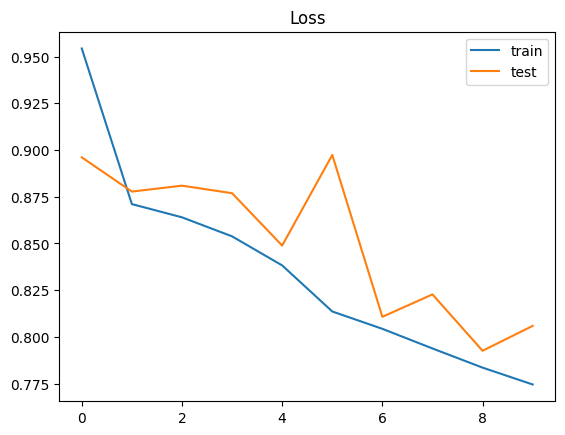

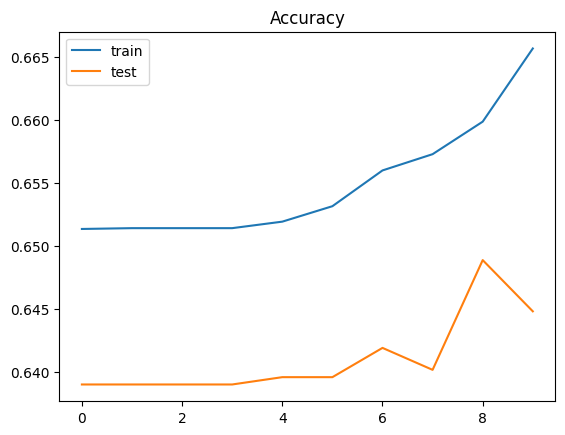

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

**GRU+Attention**

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dense, Attention, GRU
from keras.models import Model

def create_GRU_with_attention(hidden_units, dense_units, max_nb_words, embedding_dim, input_length):
    input_layer = Input(shape=(input_length,))

    # Embedding layer
    embedding_layer = Embedding(input_dim=max_nb_words, output_dim=embedding_dim, input_length=input_length, weights=[embedding_matrix],trainable=False)(input_layer)

    # LSTM layer with attention
    lstm_layer = GRU(hidden_units, return_sequences=True,dropout=0.5)(embedding_layer)
    attention_layer = attention()(lstm_layer)

    # Output layers for 3 classes
    output_layer = Dense(3, activation='softmax')(attention_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model


In [ ]:
model_attention_emb = create_GRU_with_attention(hidden_units=1000, dense_units=3, max_nb_words=100000, embedding_dim=300,
                                  input_length=128)
model_attention_emb.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 300)          30000000  
                                                                 
 gru (GRU)                   (None, 128, 1000)         3906000   
                                                                 
 attention_1 (attention)     (None, 1000)              1128      
                                                                 
 dense_2 (Dense)             (None, 3)                 3003      
                                                                 
Total params: 33910131 (129.36 MB)
Trainable params: 3910131 (14.92 MB)
Non-trainable params: 30000000 (114.44 MB)
_________________________________________________________________


In [ ]:
model_attention_emb.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), metrics=['accuracy', f1_macro, f1_weighted])
epochs = 10
batch_size = 64
history = model_attention_emb.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val,Y_val))

Epoch 1/10
243/243 [==============================] - 28s 89ms/step - loss: 0.9255 - accuracy: 0.6506 - f1_macro: 0.2729 - f1_weighted: 0.5177 - val_loss: 0.8792 - val_accuracy: 0.6390 - val_f1_macro: 0.2599 - val_f1_weighted: 0.4983
Epoch 2/10
243/243 [==============================] - 21s 85ms/step - loss: 0.8370 - accuracy: 0.6518 - f1_macro: 0.2663 - f1_weighted: 0.5153 - val_loss: 0.8213 - val_accuracy: 0.6425 - val_f1_macro: 0.2838 - val_f1_weighted: 0.5083
Epoch 3/10
243/243 [==============================] - 21s 86ms/step - loss: 0.7924 - accuracy: 0.6606 - f1_macro: 0.3298 - f1_weighted: 0.5425 - val_loss: 0.7786 - val_accuracy: 0.6547 - val_f1_macro: 0.3773 - val_f1_weighted: 0.5504
Epoch 4/10
243/243 [==============================] - 21s 85ms/step - loss: 0.7713 - accuracy: 0.6673 - f1_macro: 0.3892 - f1_weighted: 0.5718 - val_loss: 0.7615 - val_accuracy: 0.6605 - val_f1_macro: 0.3939 - val_f1_weighted: 0.5588
Epoch 5/10
243/243 [==============================] - 22s 90ms/s

In [ ]:
accr_atten = model_attention_emb.evaluate(X_test,np.array(Y_test))
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_atten[0],accr_atten[1]))

135/135 [==============================] - 3s 21ms/step - loss: 0.7405 - accuracy: 0.6782 - f1_macro: 0.4335 - f1_weighted: 0.6005
Test set
  Loss: 0.741
  Accuracy: 0.678


In [ ]:
y_pred=model_attention_emb.predict(X_test)
print(y_pred.shape)
y_pred_class= y_pred.argmax(axis=1)
y_test1=np.argmax(np.array(Y_test),axis=1)
from sklearn.metrics import classification_report,confusion_matrix
print("Performance Metrics: ")
metrics=classification_report(y_test1,y_pred_class)
print(metrics)

135/135 [==============================] - 3s 19ms/step
(4307, 3)
Performance Metrics: 
              precision    recall  f1-score   support

           0       0.66      0.21      0.32       531
           1       0.59      0.11      0.18       976
           2       0.68      0.97      0.80      2800

    accuracy                           0.68      4307
   macro avg       0.64      0.43      0.43      4307
weighted avg       0.66      0.68      0.60      4307



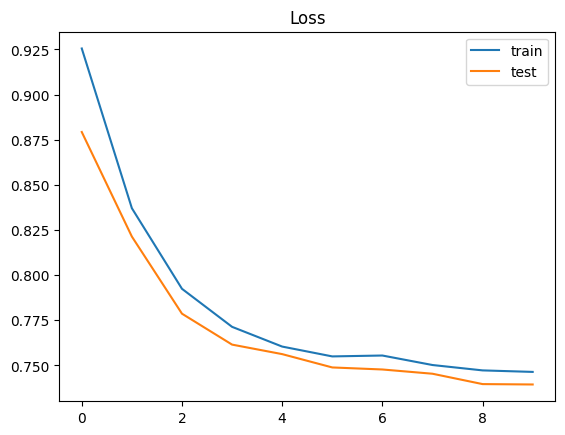

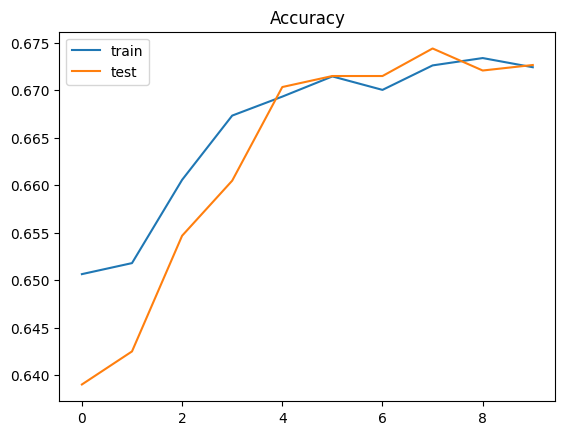

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_nb_words, output_dim=embedding_dim, input_length=input_length, weights=[embedding_matrix],trainable=False)(input_layer))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(8, activation='softmax'))
model.Summary()

NameError: ignored